<a href="https://colab.research.google.com/github/andrea-mar/BBK_MScDataScience2reddit_posts/blob/main/reddit_Posts_sentiment_SiEBERT_1epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code reference ( code was adaptaed after this): https://www.youtube.com/watch?v=vNKIg8rXK6w&t=1492s&ab_channel=rupertai

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  2 15:59:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Setup

In [3]:
# Install the transformers library
%%capture
%pip install datasets transformers==4.28.0
%pip install --upgrade accelerate
%pip install transformers
%pip install pytorch-lightning

Inspect data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [5]:
drive.mount('/content/drive', force_remount=False)
file_name = "/content/drive/MyDrive/MS_DS_NLP_project/aba_posts_labeled_cleaned.csv"

Mounted at /content/drive


In [6]:
data = pd.read_csv(file_name)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Document            974 non-null    object
 1   sentiment           974 non-null    object
 2   layperson           974 non-null    bool  
 3   aba professional    974 non-null    bool  
 4   parent              974 non-null    bool  
 5   asd                 974 non-null    bool  
 6   other_professional  974 non-null    bool  
dtypes: bool(5), object(2)
memory usage: 20.1+ KB


In [7]:
columns_to_drop = ['layperson', 'aba professional', 'parent', 'asd', 'other_professional']
data = data.drop(columns=columns_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Document   974 non-null    object
 1   sentiment  974 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB


In [8]:
data.sentiment.value_counts() # data is imbalanced -> ROC AUC and f1 bettter evaluation metrics

Neutral     621
Negative    222
Pozitive    131
Name: sentiment, dtype: int64

In [9]:
# Use pandas get_dummies to one-hot encode the 'sentiment' column
sentiment_encoded = pd.get_dummies(data['sentiment'], prefix='', prefix_sep='')

# Concatenate the new one-hot encoded columns to the original DataFrame
data = pd.concat([data, sentiment_encoded], axis=1)
data.head(2)

,Document,sentiment,Negative,Neutral,Pozitive
0,Is she in ABA therapy I only ask because my hu...,Neutral,0,1,0
1,I heard you are able to ask them questions May...,Neutral,0,1,0


In [10]:
# data was cleaned previously in the project
# split data into train and test sets
# because the dataset is small, cross validation will be used instead of a separate validation set
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=7, stratify=data['sentiment'])
data_train.shape, data_test.shape
# training set = 779 rows
# test set = 195

((779, 5), (195, 5))

In [11]:
data_train = data_train.drop(columns=['sentiment'])
data_test = data_test.drop(columns=['sentiment'])
print('train data:\n',data_train.info(), '\n')
print('test data:\n',data_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, 690 to 746
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Document  779 non-null    object
 1   Negative  779 non-null    uint8 
 2   Neutral   779 non-null    uint8 
 3   Pozitive  779 non-null    uint8 
dtypes: object(1), uint8(3)
memory usage: 14.5+ KB
train data:
 None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 135 to 361
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Document  195 non-null    object
 1   Negative  195 non-null    uint8 
 2   Neutral   195 non-null    uint8 
 3   Pozitive  195 non-null    uint8 
dtypes: object(1), uint8(3)
memory usage: 3.6+ KB
test data:
 None


In [12]:
data_train.shape, data_test.shape

((779, 4), (195, 4))

In [13]:
data_train[['Negative', 'Pozitive', 'Neutral']].value_counts() # most examples are neutral , data is imbalanced

Negative  Pozitive  Neutral
0         0         1          497
1         0         0          177
0         1         0          105
dtype: int64

In [14]:
data_train.head(3)

,Document,Negative,Neutral,Pozitive
690,Well that s a weird thing about it even being ...,0,0,1
892,Right I m getting that now as an RBT I have ol...,0,1,0
531,i ve been in the field a few years it will def...,0,1,0


In [15]:
attributes = ['Neutral', 'Negative', 'Pozitive']

Data Set

DEEP LEARNING LLMs - RoBERTa-large huggingface

Pipeline

model to fine tune : RoBERTa. - due to comutational limitations the smaller version will be used (distiledroberta).

original article : https://arxiv.org/abs/1907.11692

huggingface:
RoBERTa: https://huggingface.co/roberta-base
distilroberta: https://huggingface.co/distilroberta-base

roberta-base is case sensitive
The datasets have no stop words (droped in the data cleaning stage) - even if there is a loss of useful context in the case of RoBERTa, it was done with a perspective of having a maximum of important words within the limit of the RoBERTa maximum sequence length, which is 512 tokens. (same as this article https://hal.science/hal-03725602)




In [16]:
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from transformers import pipeline

from sklearn.model_selection import train_test_split

In [17]:
# create a pytorch Dataset object containing tokenized and vectorized data
class Reddit_Dataset(Dataset):
  def __init__(self, data, tokenizer, attributes, max_token_len: int=512):
    self.data = data # dataframe (pandas)
    self.tokenizer = tokenizer # will use the model's AutoTokenizer
    self.attributes = attributes # class labels : 'Neutral', 'Negative', 'Pozitive'
    self.max_token_len = max_token_len # 512 is the max tokens RoBERTa accepts (see above)


  def __len__(self):
    return(len(self.data))


  def __getitem__(self, index):
    item = self.data.iloc[index] # get the item in the dataframe at the given index
    text = str(item.Document) # get the text for that row and save it as a string
    attributes = torch.FloatTensor(item[self.attributes]) # get the values for 'Neutral', 'Negative', 'Pozitive' cols in a tensor format

    # tokenize the text (as PyTorch tensors)
    tokens = self.tokenizer.encode_plus(text,
                                        return_tensors='pt', # return pytorch tensors
                                        add_special_tokens=True, # adds special tokens as <EOS> - end of sentence
                                        truncation=True, # truncate the longer text
                                        max_length=self.max_token_len, # truncate the text to a max length of 512 tokens
                                        padding='max_length', # apply a padding to all text that is shorter that the max length (512)
                                        return_attention_mask=True)
    return {
        'input_ids': tokens.input_ids.flatten(),
        'attention_mask': tokens.attention_mask.flatten(),
        'labels': attributes
        }


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

# Model and tokenizer names
model_name = 'distilroberta-base'

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
trainset = Reddit_Dataset(data_train, tokenizer, attributes)
testset = Reddit_Dataset(data_test, tokenizer, attributes)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [19]:
# what the item (text representation  and labels) looks like as PyTorch tensors
trainset.__getitem__(690)

{'input_ids': tensor([   0, 6209,   79,   11,   83, 3813, 5804,   38,  129, 1394,  142,  127,
         1623,   16,   10, 9543, 3813,    8,   37,   34,   10, 3653, 1122,    7,
           42,   20, 4607,   18, 1041,   32,  562, 2997,    8,   65,    9,    5,
          383,   51,   32,  447,   16, 1903,    5, 4607,   98,   51,   64,   28,
           23,    5, 3312,  396,  143,  743,    2,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1, 

In [20]:
len(trainset), len(testset)

(779, 195)

Data module

In [21]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from pytorch_lightning import LightningDataModule
from typing import Optional

In [27]:
class Reddit_Data_Module(LightningDataModule):
    def __init__(
        self,
        traindata,
        testdata,
        attributes,
        model_name="roberta-base",  # default model name if not provided
        k: int = 1,  # fold number
        num_splits: int = 10,
        split_seed = 7, # split the folds consistently the same each time code runs
        batch_size: int = 4,
        max_token_len: int=128,
        num_workers: int = 1, # number of cpus used
    ):
        super().__init__()

        # save hyperparameters ( this allows use of self.hparams.<hparam>)
        self.save_hyperparameters()
        self.traindata = traindata
        self.testdata = testdata
        self.attributes = attributes

        # initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.hparams.model_name)

        # data transformations
        self.transforms = None

        # Initialize datasets as None
        self.data_train = None
        self.data_val = None
        self.data_test = None

    def setup(self, stage=None):
        if not self.data_train and not self.data_val:
            # split the training data into k folds for training and validation
            kf = KFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
            all_splits = [k for k in kf.split(self.traindata)]
            train_indexes, val_indexes = all_splits[self.hparams.k]
            train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

            # create training and validation datasets
            trainset = Reddit_Dataset(data_train, tokenizer, attributes)

            self.data_train = Reddit_Dataset(self.traindata.iloc[train_indexes], self.tokenizer, self.attributes)
            self.data_val = Reddit_Dataset(self.traindata.iloc[val_indexes], self.tokenizer, self.attributes)

        if stage == 'predict':
            self.data_test = Reddit_Dataset(self.testdata, self.tokenizer, self.attributes)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            # pin_memory=self.hparams.pin_memory,
        )

In [28]:
reddit_module = Reddit_Data_Module(data_train, data_test, attributes)

In [29]:
reddit_module.setup()

In [30]:
dl = reddit_module.train_dataloader()

In [31]:
len(dl)

176

Model

In [32]:
from transformers import AutoModel, get_cosine_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [33]:
class Reddit_Classifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    # save and pass the parameters in a separate dict (makes it easier to change)
    self.config = config
    # get the pretrained model
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
    # append a classification layer to the pretrained model (2 layers to be have better performance: one hidden, one classification output)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    # initialize weights for the 2 layers
    torch.nn.init.xavier_uniform(self.hidden.weight)
    torch.nn.init.xavier_uniform(self.classifier.weight)
    # loss function
    # PyTorch documentation:
    # This loss combines a Sigmoid layer and the BCELoss in one single class.
    # This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability
    self.loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    # create drop out layer - prevent overfitting
    self.dropout = nn.Dropout()


  def forward(self, input_ids, attention_mask, labels=None):
    # pretrained model
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    # get the output of the last hidden layer of the pretrained model
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # nn classification layers - feed the output of the pretrained model to the new layers we created
    pooled_output = self.hidden(pooled_output)  # new hidden layer
    pooled_output = self.dropout(pooled_output) # add dropout before the activation function (because we use relu this layer needs to be before - see AML lectures)
    pooled_output = F.relu(pooled_output) # use relu activation function before the output layer
    logits = self.classifier(pooled_output) # classification / final output layer
    # compute the loss
    loss = 0
    if labels is not None:
      loss = self.loss_function(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return {'loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('validation loss', loss, prog_bar=True, logger=True)
    return {'val_loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]

Train

In [34]:
config = {
    'model_name': 'siebert/sentiment-roberta-large-english',
    'n_labels': len(attributes),
    'batch_size': 4,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(reddit_module.train_dataloader()),
    'w_decay': 0.001,
    'n_epoch': 1 # test the asumption of the SiEBERT authors that the model can achieve around 70% accuracy after 1 epoch of training on a new small dataset
}

In [ ]:
# np.random.seed(7)
# model = Reddit_Classifier(config)

In [ ]:
# # check the model is working on one case ( bug and output check )
# idx = 690
# input_ids = trainset.__getitem__(idx)['input_ids']
# att_mask = trainset.__getitem__(idx)['attention_mask']
# labels = trainset.__getitem__(idx)['labels']
# loss, output = model(input_ids.unsqueeze(dim=0), att_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))


In [ ]:
# loss, output

Train

In [52]:
# from pytorch_lightning.callbacks import EarlyStopping

# # prevent overfitting
# # early stopping callback
# early_stopping_callback = EarlyStopping(
#     monitor='validation loss',  # metric to monitor
#     min_delta=0.001,  # min change in validation loss to be considered an improvement
#     patience=10,  # Nnumber of epochs with no improvement before stopping
#     verbose=True,
#     mode='min'  # 'min' because we want to minimize loss
# )

In [35]:
from pytorch_lightning import Trainer, seed_everything
torch.cuda.empty_cache()

seed_everything(42, workers=True)

# train module
train_module = Reddit_Data_Module(data_train, data_test, attributes, batch_size=config['batch_size'])
train_module.setup()

# model
model = Reddit_Classifier(config)

# train
trainer = pl.Trainer(
    max_epochs=config['n_epoch'],
    num_sanity_val_steps=2,
    accelerator="auto"
    # callbacks=[early_stopping_callback] this is not needed at for this training as in only trains for 1 epoch
    )

trainer.fit(model, train_module)

INFO:lightning_fabric.utilities.seed:Seed set to 42


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the model checkpoint at siebert/sentiment-roberta-large-english were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-33-65a3fd75950d>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.hidden.weight)
<ipython-input-33-65a3fd75950d>:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [41]:
# %load_ext tensorboard


In [42]:
# %tensorboard --logdir '/content/lightning_logs/version_0'

In [43]:
# !ls -l

In [44]:
# !lsof -i :6006


In [45]:
# !kill 8563

In [46]:
# from tensorboard import notebook
# notebook.list()

In [47]:
# notebook.display(port=6006, height=500)

In [48]:
# !tensorboard dev upload \
#   --logdir '/content/lightning_logs/version_0' \
#   --name 'ditilroberta finetuned' \
#   --description 'ditilroberta finetuned to reddit data' \
#   --one_shot

In [50]:
# import psutil
# print(f"Memory Usage: {psutil.virtual_memory()}")

In [51]:
# Save the trained model
# trainer.save_checkpoint("/content/drive/MyDrive/MS_DS_NLP_project/models/Sentiment_SiEBERT_1epoch.ckpt")

Predict with model

In [36]:
# # method to convert list of text into predictions for each text
def classify_raw_text(model, dm, num_threads=1):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # set the number of CPU threads
  torch.set_num_threads(num_threads)

  predictions = trainer.predict(model, dm)
  flatten_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flatten_predictions


In [37]:
try:
    predictions = classify_raw_text(model, train_module)
except Exception as e:
    print(f"An error occurred: {e}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

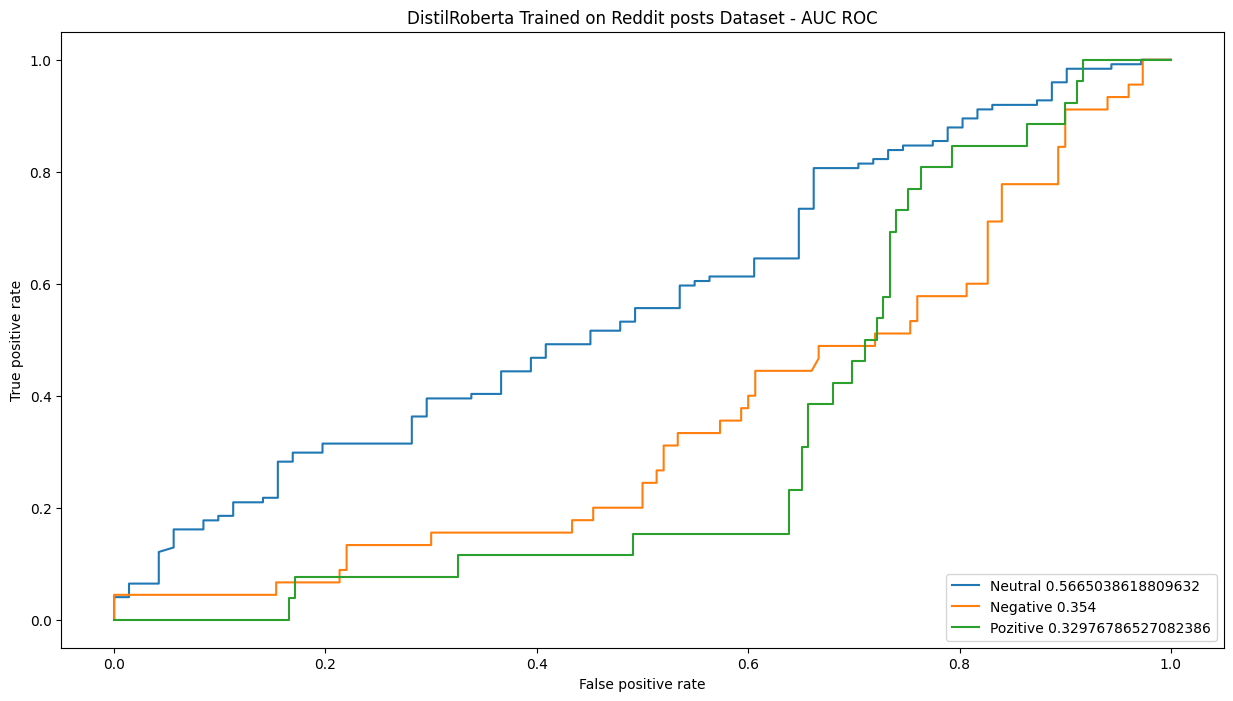

In [38]:
test_data_labels = np.array(data_test[attributes])

from sklearn import metrics

plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      test_data_labels[:,i].astype(int), predictions[:,i]
  )
  auc = metrics.roc_auc_score(
      test_data_labels[:,i].astype(int), predictions[:,i]
  )
  plt.plot(fpr, tpr, label=f'{attribute} {auc}')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.legend(loc='lower right')
  plt.title('DistilRoberta Trained on Reddit posts Dataset - AUC ROC')

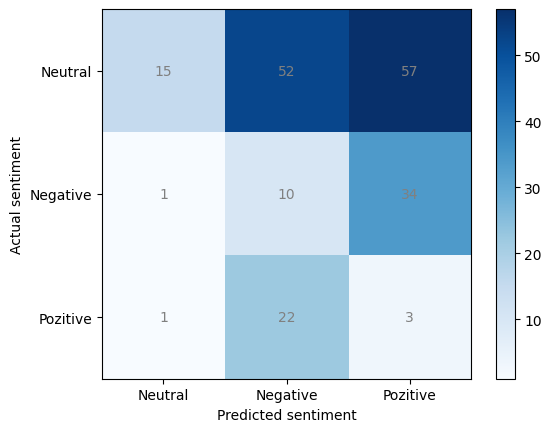

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# convert probabilities to class labels
predictions_labels = np.argmax(predictions, axis=1)

# create a confusion matrix
conf_matrix = confusion_matrix(test_data_labels.argmax(axis=1), predictions_labels)

# plot confusion matrix for test set
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()

# add labels and ticks
tick_marks = np.arange(len(attributes))
plt.xticks(tick_marks, attributes)
plt.yticks(tick_marks, attributes)
plt.xlabel("Predicted sentiment")
plt.ylabel("Actual sentiment")

# display the values in each cell
for i in range(len(attributes)):
    for j in range(len(attributes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='grey')

plt.show()

# most neutral post were classified correctly , the other classe were not classified correctly ( probabliy due to smaller number of examples, the model was not able to learn the relevant patterns)
# the model does not seem to be able to identify the pozitive class at all



In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# round predictions to convert probabilities to binary values (0 or 1)
rounded_predictions = predictions.round()

# accuracy score
accuracy = accuracy_score(test_data_labels, rounded_predictions)

# precision, recall, and F1 score (compute the weighted version for all metrics as this take into account the class imbalance/distribution)
precisions = precision_score(test_data_labels, rounded_predictions, average='weighted')
recalls = recall_score(test_data_labels, rounded_predictions, average='weighted')
f1_scores = f1_score(test_data_labels, rounded_predictions, average='weighted')
f2_scores = fbeta_score(test_data_labels, rounded_predictions, beta=2, average='weighted')

print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precisions}")
print(f"Recall:     {recalls}")
print(f"F1 Score:   {f1_scores}")
print(f"F2 Score:   {f2_scores}")


# F1 score indicates the model performs only slightly better than chance (0.64)


Accuracy:   0.0564
Precision:  0.5001152596908263
Recall:     0.4307692307692308
F1 Score:   0.36730603454404104
F2 Score:   0.36832215088660974


In [49]:
# the finetuned distilroberta model ( using subreddits data )
print(model)

Reddit_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
       